In [1]:
!pip install pandas scikit-learn optuna statsmodels scikit-optimize

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import optuna
import os
import logging
from include.utils import incrementar_dados_aleatorios_csv, categorizar_imc, check_modelo_nan_inf
from include.utils import prever_encargos_futuros, segmentacao_de_risco, analise_de_sensibilidade, otimizacao_de_recursos, planejamento_estrategico

In [3]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

**1. Engenharia de Recursos**

Novos recursos derivados dos dados existentes

In [4]:
# Obtém a largura do terminal - uso mais embaixo nos prints
terminal_width = os.get_terminal_size().columns

dados = pd.read_csv('../planilhas/2_dados_aleatorios_sobre_original.csv', encoding='latin-1')

# Aplicar a função para categorizar IMC e criar uma nova coluna 'Categoria_IMC'
dados['Categoria_IMC'] = dados['IMC'].apply(categorizar_imc)

print(dados)

      Idade     Gênero    IMC  Filhos Fumante    Região  Encargos  \
0      56.0   feminino  29.77     2.0     sim  sudoeste  31109.89   
1      46.0  masculino  25.86     1.0     não  nordeste  26650.70   
2      32.0  masculino  23.01     0.0     não  sudoeste  21459.04   
3      59.0  masculino    NaN     2.0     sim  noroeste   6388.89   
4       NaN  masculino  30.15     NaN     não   sudeste   1057.56   
...     ...        ...    ...     ...     ...       ...       ...   
1998   36.0   feminino  30.92     3.0     sim  noroeste   5545.01   
1999   40.0  masculino  19.62     1.0     não   sudeste   4124.43   
2000   73.0   feminino  23.28     3.0     sim  nordeste   7671.59   
2001   76.0   feminino  33.53     3.0     NaN  noroeste   7506.31   
2002   53.0  masculino  32.88     2.0     sim       NaN   5945.15   

       Categoria_IMC  
0          Sobrepeso  
1          Sobrepeso  
2        Peso normal  
3     Valor Inválido  
4              Obeso  
...              ...  
1998      

**2. Limpeza de Dados**

In [5]:
# Caso exista, removendo linhas com valores NaN
dados = dados.dropna()

# Substituir valores nulos para o valor esperado
dados['Filhos'] = dados['Filhos'].fillna(0)
dados['Idade'] = dados['Idade'].fillna(0)
dados['Gênero'] = dados['Gênero'].fillna('Não informado')
dados['Fumante'] = dados['Fumante'].fillna('não')

#Convertendo colunas para o tipo esperado
dados['Filhos'] = dados['Filhos'].astype(int)
dados['Idade'] = dados['Idade'].astype(int)

print(dados)

      Idade     Gênero    IMC  Filhos Fumante    Região  Encargos  \
0        56   feminino  29.77       2     sim  sudoeste  31109.89   
1        46  masculino  25.86       1     não  nordeste  26650.70   
2        32  masculino  23.01       0     não  sudoeste  21459.04   
8        45  masculino  20.76       3     sim  nordeste   5817.88   
12       79   feminino  34.06       1     não  nordeste   6324.29   
...     ...        ...    ...     ...     ...       ...       ...   
1995     36   feminino  21.83       2     não  nordeste   3769.51   
1997     30   feminino  29.27       1     não  noroeste   3493.29   
1998     36   feminino  30.92       3     sim  noroeste   5545.01   
1999     40  masculino  19.62       1     não   sudeste   4124.43   
2000     73   feminino  23.28       3     sim  nordeste   7671.59   

     Categoria_IMC  
0        Sobrepeso  
1        Sobrepeso  
2      Peso normal  
8      Peso normal  
12           Obeso  
...            ...  
1995   Peso normal  
199

**3. Pré-processamento**

In [6]:
# Dividir os dados em features (X) e target (y)
X = dados.drop(['Encargos','Categoria_IMC','Gênero','Região'], axis=1)  # descartando colunas não necessárias para o teste
y = dados['Encargos']

# Codificar variáveis com LabelEncoder
label_encoder = LabelEncoder()
X['Fumante'] = label_encoder.fit_transform(X['Fumante'])

# Substituir valores 'sim' e 'não' por 1 e 0 (comentei porque o resultado é o mesmo no LabelEncoder
#X['Fumante'] = X['Fumante'].map({'sim': 1, 'não': 0})

print(X)

      Idade    IMC  Filhos  Fumante
0        56  29.77       2        1
1        46  25.86       1        0
2        32  23.01       0        0
8        45  20.76       3        1
12       79  34.06       1        0
...     ...    ...     ...      ...
1995     36  21.83       2        0
1997     30  29.27       1        0
1998     36  30.92       3        1
1999     40  19.62       1        0
2000     73  23.28       3        1

[1054 rows x 4 columns]


In [7]:
# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Inicializar o StandardScaler, que é usado para padronizar os recursos
scaler = StandardScaler()

# Aplicar a transformação de padronização nos dados de treinamento e ajustar o scaler aos dados
X_train_scaled = scaler.fit_transform(X_train)

# Aplicar a mesma transformação de padronização aos dados de teste
X_test_scaled = scaler.transform(X_test)

# Calcular a matriz de correlação dos dados de treinamento
correlation_matrix = X_train.corr()
print('Visualizar a matriz de correlação:')
print(correlation_matrix)

Visualizar a matriz de correlação:
            Idade       IMC    Filhos   Fumante
Idade    1.000000  0.037765  0.067959  0.053843
IMC      0.037765  1.000000 -0.009634  0.081850
Filhos   0.067959 -0.009634  1.000000 -0.015647
Fumante  0.053843  0.081850 -0.015647  1.000000


**Validação estatística**

Utilizando métricas estatísticas para validar a eficácia do modelo (p-value, intervalos de confiança):            

In [8]:
dados_aux = dados.copy()

dados_aux['Fumante'] = dados_aux['Fumante'].map({'sim': 1, 'não': 0})

# Adicione uma coluna de intercepto aos dados
dados_aux['Intercepto'] = 1

# Dividindo os dados em variáveis independentes (X) e variável dependente (y)
X = dados_aux[['Idade', 'Filhos', 'Fumante']]
y = dados_aux['Encargos']

# Ajustando o modelo de regressão linear usando OLS (Ordinary Least Squares)
modelo = sm.OLS(y, X).fit()

# Calculando os p-values dos coeficientes
p_values = modelo.summary2().tables[1]['P>|t|']

# Calculando os intervalos de confiança dos coeficientes
conf_intervals = modelo.conf_int()

# Imprima os resultados
print("P-values dos coeficientes:")
print(p_values)
print("\nIntervalos de Confiança dos coeficientes:")
print(round(conf_intervals,2))

P-values dos coeficientes:
Idade      0.000000e+00
Filhos     3.223529e-51
Fumante    1.527888e-20
Name: P>|t|, dtype: float64

Intervalos de Confiança dos coeficientes:
              0       1
Idade     77.14   82.45
Filhos   463.33  593.72
Fumante  573.11  871.99


**4. Treinamento do Modelo**

In [9]:
# Adicionando mais modelos ao dicionário de modelos
models = {
    'Random Forest Regressor': RandomForestRegressor(),
    'Linear Regression': LinearRegression(),
    'Support Vector Regression': SVR(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'Lasso Regression': Lasso()
}

# Definindo os espaços de busca para os hiperparâmetros de cada modelo
param_spaces = {
    'Random Forest Regressor': {
        'n_estimators': Integer(100, 300),
        'max_depth': Integer(1, 10)
    },
    'Support Vector Regression': {
        'C': Real(0.1, 10, prior='log-uniform'),
        'gamma': Categorical(['scale', 'auto'])
    },
    'Decision Tree Regressor': {
        'max_depth': Integer(1, 10)
    },
    'K-Nearest Neighbors Regressor': {
        'n_neighbors': Integer(3, 10)
    },
    'Gradient Boosting Regressor': {
        'n_estimators': Integer(100, 300),
        'max_depth': Integer(1, 10)
    },
    'Lasso Regression': {
        'alpha': Real(0.1, 10, prior='log-uniform')
    }
}

In [10]:
# usado no método abaixo BayesSearchCV (como demora um pouco, caso seja necessário, basta reduzir a quantidade de interações
numero_interacoes_bayes_search = 10

# Treinamento e avaliação dos modelos com BayesSearchCV
for name, model in models.items():
    # Imprime uma linha separadora com base na largura do terminal
    print('-' * terminal_width)
    
    try:
        check_modelo_nan_inf(model, X_train, y_train)
        print(f"Modelo {name}: OK. Sem NaN e Inf nas previsões do modelo")
    except ValueError as e:
        print(f"{name}: {e}")
    
    if name in param_spaces:
        bayes_search = BayesSearchCV(model, param_spaces[name], cv=5, scoring='neg_mean_squared_error', n_iter=numero_interacoes_bayes_search, random_state=42)
        bayes_search.fit(X_train, y_train)
        model = bayes_search.best_estimator_
        print(f"Melhores parâmetros para {name}: {bayes_search.best_params_}")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print(f'{name} MSE: {round(mse,2)}')
    # Calcular acurácia média usando validação cruzada
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f'Acurácia média com validação cruzada para {name}: {round(scores.mean(),2)}')
    
    # Calcula e exibe a importância das características para o modelo atual
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Importância': model.feature_importances_})
        importance_df = importance_df.sort_values(by='Importância', ascending=False)
        print(f"Importância das características para {name}:")
        print(round(importance_df,2))
    elif isinstance(model, LinearRegression) or isinstance(model, Lasso):
        importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Coeficiente': model.coef_})
        importance_df = importance_df.sort_values(by='Coeficiente', ascending=False)
        print(f"Coeficientes das características para {name}:")
        print(round(importance_df,2))
    elif isinstance(model, SVR):
        support_indices = model.support_
        support_features = X_train.iloc[support_indices]
        feature_importance_svr = support_features.mean(axis=0)
        importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Importância': feature_importance_svr})
        importance_df = importance_df.sort_values(by='Importância', ascending=False)
        print(f"Importância das características para {name}:")
        print(round(importance_df,2))
    else:
        print(f"Não é possível calcular a importância das características para o modelo {name}")

--------------------------------------------------------------------------------------------------------------------------------------------------------------
Modelo Random Forest Regressor: OK. Sem NaN e Inf nas previsões do modelo
Melhores parâmetros para Random Forest Regressor: OrderedDict({'max_depth': 5, 'n_estimators': 246})
Random Forest Regressor MSE: 615669.25
Acurácia média com validação cruzada para Random Forest Regressor: 0.49
Importância das características para Random Forest Regressor:
   Colunas  Importância
0    Idade         0.58
1      IMC         0.27
2   Filhos         0.10
3  Fumante         0.05
--------------------------------------------------------------------------------------------------------------------------------------------------------------
Modelo Linear Regression: OK. Sem NaN e Inf nas previsões do modelo
Linear Regression MSE: 72935.48
Acurácia média com validação cruzada para Linear Regression: 0.58
Coeficientes das características para Linear Reg

**5. Comparação de Modelos**

In [11]:
# Seleção de modelo com base na maior pontuação de validação cruzada
best_model_name = max(models, key=lambda model: cross_val_score(models[model], X_train, y_train, cv=5).mean())

**6. Seleção de Modelo**

In [12]:
best_model = models[best_model_name]
print(f'Best Model: {best_model_name}')

Best Model: Linear Regression


**7. Otimização de Modelo**

In [13]:
# Função para criar uma nova instância do modelo com hiperparâmetros definidos
def create_model(trial):
    if best_model_name == 'Random Forest Regressor':
        n_estimators = trial.suggest_int('n_estimators', 10, 100)
        max_depth = trial.suggest_int('max_depth', 2, 32)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        model = RandomForestRegressor(n_estimators=n_estimators, 
                                       max_depth=max_depth, 
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf)
    elif best_model_name == 'Decision Tree Regressor':
        max_depth = trial.suggest_int('max_depth', 2, 32)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        model = DecisionTreeRegressor(max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf)
    elif best_model_name == 'Support Vector Regression':
        C = trial.suggest_loguniform('C', 1e-3, 1e3)
        epsilon = trial.suggest_loguniform('epsilon', 1e-3, 1e1)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
        model = SVR(C=C, epsilon=epsilon, kernel=kernel)
    elif best_model_name == 'Linear Regression':
        model = LinearRegression()
    elif best_model_name == 'K-Nearest Neighbors Regressor':
        n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
        model = KNeighborsRegressor(n_neighbors=n_neighbors)
    elif best_model_name == 'Gradient Boosting Regressor':
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.1)
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        model = GradientBoostingRegressor(learning_rate=learning_rate, 
                                           n_estimators=n_estimators, 
                                           max_depth=max_depth)
    else:
        model = models[best_model_name]  # Usar os hiperparâmetros padrão para outros modelos
    return model

# Função para otimização de hiperparâmetros
def objective(trial):
    # Criar uma nova instância do modelo com hiperparâmetros definidos pelo Optuna
    model = create_model(trial)
    
    # Avaliação do modelo utilizando validação cruzada
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=3, scoring='neg_mean_squared_error').mean()
    return score

# Criar o objeto de estudo Optuna
study = optuna.create_study(direction='minimize')

# Realizar a otimização dos hiperparâmetros
study.optimize(objective, n_trials=50)

[I 2024-04-13 12:41:00,480] A new study created in memory with name: no-name-8a8f9053-5711-4bae-8d66-1167d6da0c4a
[I 2024-04-13 12:41:02,754] Trial 0 finished with value: -1805942.080316807 and parameters: {}. Best is trial 0 with value: -1805942.080316807.
[I 2024-04-13 12:41:04,533] Trial 1 finished with value: -1805942.080316807 and parameters: {}. Best is trial 0 with value: -1805942.080316807.
[I 2024-04-13 12:41:06,500] Trial 2 finished with value: -1805942.080316807 and parameters: {}. Best is trial 0 with value: -1805942.080316807.
[I 2024-04-13 12:41:06,529] Trial 3 finished with value: -1805942.080316807 and parameters: {}. Best is trial 0 with value: -1805942.080316807.
[I 2024-04-13 12:41:06,554] Trial 4 finished with value: -1805942.080316807 and parameters: {}. Best is trial 0 with value: -1805942.080316807.
[I 2024-04-13 12:41:06,571] Trial 5 finished with value: -1805942.080316807 and parameters: {}. Best is trial 0 with value: -1805942.080316807.
[I 2024-04-13 12:41:06

In [14]:
# Obtenha os melhores parâmetros do estudo Optuna
best_params = study.best_params
best_score = study.best_value

# Configure o modelo com os melhores parâmetros
best_model.set_params(**best_params)

# Ajuste o modelo aos dados de treinamento
best_model.fit(X_train, y_train)

# Avaliação do modelo
score_train = model.score(X_train, y_train)
score_test = model.score(X_test, y_test)

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# Imprimir resultados
print("\nMelhores parâmetros:", best_params)
print("\nMelhor score:", round(best_score,2))
print(f"\nScore treino: {round(score_train,2)}")
print(f"\nScore teste: {round(score_test,2)}")
print(f'\nOptimized {best_model_name} MSE: {round(mse,2)}')


Melhores parâmetros: {}

Melhor score: -1805942.08

Score treino: 0.45

Score teste: 0.95

Optimized Linear Regression MSE: 72935.48


In [15]:
# Obter a importância das características apenas para modelos que suportam esse atributo
if hasattr(best_model, 'feature_importances_'):
    # Obter a importância das características do modelo
    feature_importances = best_model.feature_importances_
    
    # Criar um DataFrame para visualizar a importância das características
    importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Importância': feature_importances})

    # Ordenar as características por importância
    importance_df = importance_df.sort_values(by='Importância', ascending=False)
    
    print("\nQuais características individuais têm maior impacto nos custos médicos cobrados pelo seguro de saúde?")
    print(round(importance_df,2))

    # Selecionar as características mais importantes (por exemplo, as 10 mais importantes)
    top_features = importance_df.head(10)['Colunas'].tolist()  # Ajuste o número conforme necessário
    
    # Calcular a matriz de correlação apenas para as características mais importantes
    correlation_matrix = X_train[top_features].corr()
    
    # Visualizar a matriz de correlação
    print("\nExiste alguma correlação entre certas características (por exemplo, idade, IMC) e os custos médicos?")
    print(correlation_matrix)
else:
    print("O modelo selecionado não suporta o cálculo de importância das características.")

O modelo selecionado não suporta o cálculo de importância das características.


In [16]:
# Validação cruzada para detecção de overfitting
def overfitting_detection(model, X, y, cv=5):
    train_mse = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error').mean()
    model.fit(X, y)
    y_pred_train = model.predict(X)
    test_mse = np.mean((y - y_pred_train) ** 2)
    return train_mse, test_mse

# Exemplo de uso
train_mse, test_mse = overfitting_detection(best_model, X_train_scaled, y_train)

print("MSE no conjunto de treinamento:", round(train_mse,2))
print("MSE no conjunto de teste:", round(test_mse,2))

MSE no conjunto de treinamento: 1799165.8
MSE no conjunto de teste: 1782490.17


**8. Entrega dos dados futuros**

In [17]:
# Definição de dados futuros - 200 linhas
dados_futuros = pd.DataFrame(np.random.rand(200, len(X_test.columns)), columns=X_test.columns)
print(dados_futuros.head())

      Idade       IMC    Filhos   Fumante
0  0.782278  0.195812  0.696127  0.633720
1  0.898785  0.753790  0.493216  0.212031
2  0.783101  0.208341  0.992952  0.933014
3  0.419428  0.397920  0.720590  0.376905
4  0.593486  0.988864  0.531495  0.449626


Modelo treinado para fazer previsões dos encargos futuros:

In [18]:
encargos_futuros = prever_encargos_futuros(best_model, dados_futuros)

C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Grupos de indivíduos com diferentes níveis de risco

In [19]:
grupos_risco = segmentacao_de_risco(best_model, dados_futuros)

C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Análises de sensibilidade para entender o impacto das mudanças nas características dos segurados nos encargos previstos:

In [20]:
encargos_futuros_expectativa_40_anos = analise_de_sensibilidade(best_model, dados_futuros, 'Idade', novo_valor=40)

C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Utilizando as previsões dos encargos para otimizar a alocação de recursos:

In [21]:
recursos_otimizados = otimizacao_de_recursos(encargos_futuros)

Utilizando as informações obtidas com o modelo para desenvolver planos estratégicos:

In [22]:
planos_estrategicos = planejamento_estrategico(best_model, dados_futuros)

C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [23]:
# Adicionando as novas colunas na planilha dados futuros
dados_futuros['Encargos Reais'] = np.nan # não consegui ainda obter (dúvida com o professor)
dados_futuros['Encargo Futuro'] = encargos_futuros
dados_futuros['Grupos Risco'] = grupos_risco
dados_futuros['Encargo Futuro - Expectativa 40 anos'] = encargos_futuros_expectativa_40_anos
dados_futuros['Otimização Recursos'] = recursos_otimizados
dados_futuros['Planos estratégicos'] = planos_estrategicos

# Salvar os dados randômicos futuros
dados_futuros.to_csv("../planilhas/4_dados_futuros.csv", index=False, encoding='latin1')

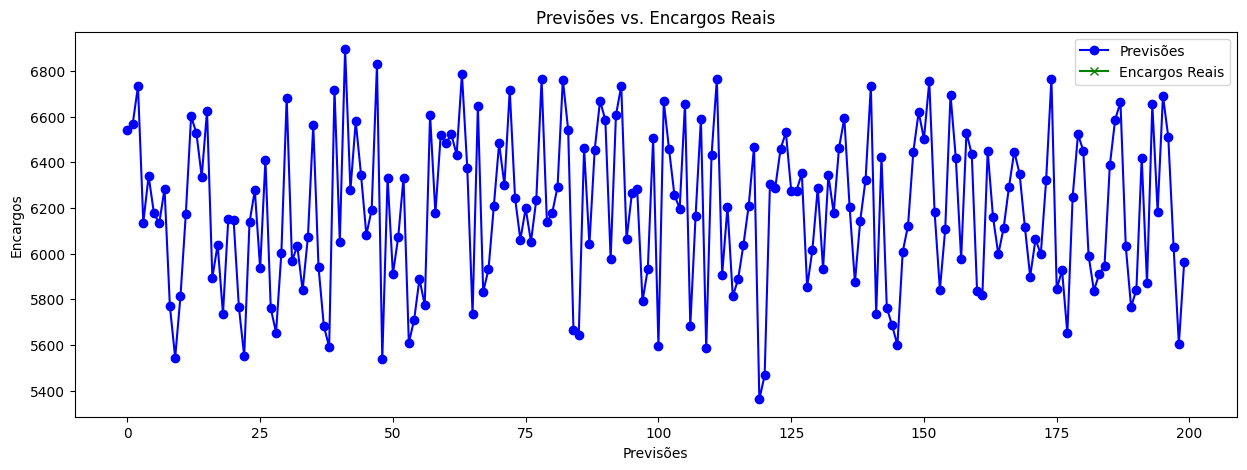

In [24]:
fig, axs = plt.subplots(figsize=(15, 5))

plt.plot(dados_futuros['Encargo Futuro'], label='Previsões', color='blue', marker='o')
plt.plot(dados_futuros['Encargos Reais'], label='Encargos Reais', color='green', marker='x')

plt.xlabel('Previsões')
plt.ylabel('Encargos')
plt.legend()
plt.title('Previsões vs. Encargos Reais')
plt.show()